In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 99

In [2]:
os.chdir('..')  # change to root directory

In [3]:
# Load data
import pickle
from firenet.util import add_uncertainty_features
with open('./data/d_data.pkl', 'rb') as infile:
    d_data = pickle.load(infile)
    
d_data = add_uncertainty_features(d_data)
d_data.keys()

dict_keys(['fullbay', 'fullbayerr', 'shortbay', 'shortbayerr', 'redshift', 'observed', 'observederr', 'obserr_to_short', 'obs_to_short'])

# Single train/test split

In [4]:
from firenet.ml.reguncpredictor import RegUncPredictor

pred = RegUncPredictor(d_data)
pred.preprocess()
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.8486        0.6310     +  0.0721
      2        0.5355        0.3727     +  0.0770
      3        0.3789        0.3077     +  0.0772
      4        0.3273        0.2801     +  0.0804
      5        0.3036        0.2586     +  0.0734
      6        0.2847        0.2447     +  0.0755
      7        0.2690        0.2332     +  0.0736
      8        0.2565        0.2250     +  0.0767
      9        0.2463        0.2188     +  0.0784
     10        0.2385        0.2144     +  0.0761
     11        0.2321        0.2108     +  0.0764
     12        0.2267        0.2080     +  0.0729
     13        0.2220        0.2057     +  0.0734
     14        0.2178        0.2035     +  0.0725
     15        0.2138        0.2014     +  0.0652
     16        0.2103        0.2000     +  0.0809
     17        0.2070        0.1983     +  0.0762
     18        0.2039        0.1967     +  0.0743


In [5]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      293.9592       71.7005     +  0.1457
      2     -231.8511     -612.2812     +  0.1118
      3    -1084.7638    -1469.0460     +  0.0800
      4    -1914.4313    -2077.7714     +  0.0684
      5    -2447.1195    -2407.4994     +  0.0772
      6    -2741.1793    -2572.5723     +  0.0726
      7    -2899.8625    -2655.2042     +  0.0783
      8    -2988.9426    -2700.3834     +  0.0758
      9    -3043.8697    -2728.9289     +  0.0722
     10    -3081.4335    -2748.8136     +  0.0702
     11    -3108.9031    -2763.7905     +  0.0730
     12    -3129.7182    -2775.1686     +  0.0687
     13    -3145.8858    -2783.9097     +  0.0711
     14    -3158.8489    -2790.8203     +  0.0768
     15    -3169.5707    -2796.7097     +  0.0730
     16    -3178.8027    -2801.8810     +  0.0820
     17    -3186.8169    -2806.4092     +  0.0728
     18    -3193.8236    -2810.4265     +  0.0747


In [6]:
pred.reg.test()

PACS_70      0.218264
PACS_100     0.192286
PACS_160     0.174473
SPIRE_250    0.187326
SPIRE_350    0.201136
SPIRE_500    0.215347
Name: rmse, dtype: float64

In [7]:
pred.unc.test()

PACS_70      1.111108
PACS_100     1.156953
PACS_160     1.222458
SPIRE_250    1.084627
SPIRE_350    1.020382
SPIRE_500    0.976337
Name: mean_chisq, dtype: float64

In [8]:
y_t, y_p, y_perr = pred.get_target_set()

In [9]:
# Storing and loading models
from firenet.ml.modelstore import ModelStore

ModelStore().store(pred, name='nnet')  # Save to './models/nnet.pkl' by default
pred = ModelStore().load(d_data, name='nnet')  # Load "nnet" model

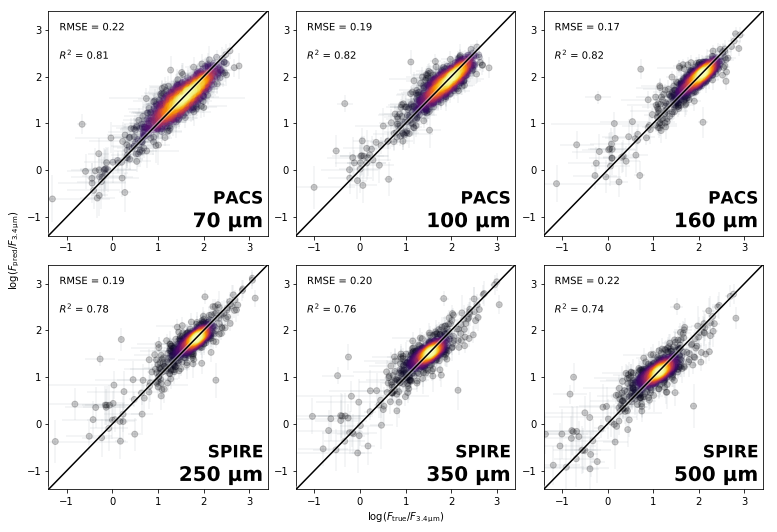

In [10]:
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Full set predictor
Using a 4-fold train/test split, training 4 predictors. Each galaxy is used as a test sample once.

In [11]:
from firenet.ml.fullsetpredictor import FullSetPredictor
fspred = FullSetPredictor(d_data)

In [12]:
fspred.prepare_splits(shuffle_state=123)

In [13]:
fspred.train()

Start training model 1/4...
Start training model 2/4...
Start training model 3/4...
Start training model 4/4...


In [14]:
# Storing and loading models
from firenet.ml.modelstore import ModelStore

ModelStore().store(fspred, name='fsnnet')  # Save to './models/fsnnet.pkl' by default
fspred = ModelStore().load(d_data, name='fsnnet')  # Load "fsnnet" model

In [15]:
y_t, y_p, y_perr = fspred.get_combined_test()

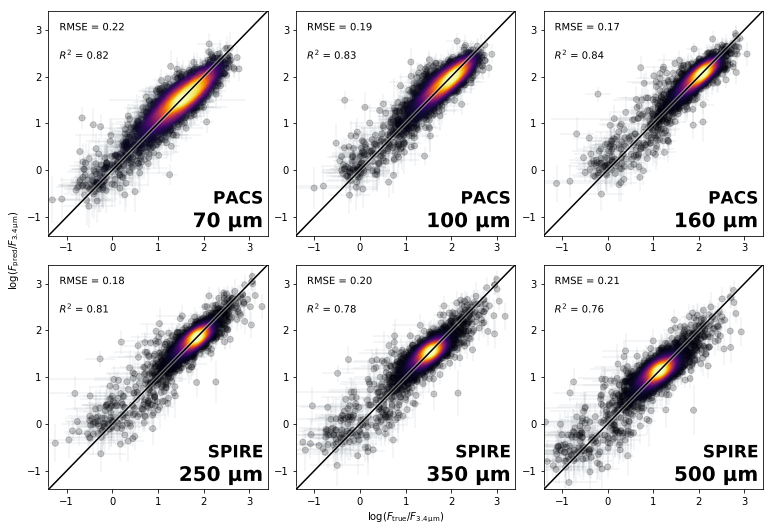

In [16]:
# See paper Fig. 3
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')